In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

The dataset contains 1040 captcha files as png images. The label for each sample is a string, the name of the file (minus the file extension). We will map each character in the string to an integer for training the model. Similary, we will need to map the predictions of the model back to strings. For this purpose we will maintain two dictionaries, mapping characters to integers, and integers to characters, respectively.

In [16]:
# Path to the data directory
data_dir = Path("./data/captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png"))))) #get all .png files and sorted the list in alphabetical order
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = sorted(list(set(char for label in labels for char in label))) #get all the characters in all the labels, remove non unique values with (set) and sorted the result

print(f"Number of images found : {len(images)}")
print(f"Number of labels found : {len(labels)}")
# print(f"Number of unique characters: {len(characters)}")
# print(f"characters present: {characters}")


# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])



Number of images found : 1040
Number of labels found : 1040


Preprocessing

In [13]:
# Mapping characters to integers : return a class constructor ?
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
# Mapping characters integers back to original characters : return a class constructor ?
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

# Function to split the dataset between training set and validation set
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the sataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training sample
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Splitting data into training and validation set
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to gray scale (channels = 1 = grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert in float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image data array because we want the time
    # dimension to corresponde to the width of the image (e.g. make the width appear first and then the height)
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two outputs
    return {"image": img, "label": label}


Create Dataset object

In [14]:
# 1. Create training dataset :
# map over the dataset and apply encode_single_sample
# tf.data.AUTOTUNE lets tf decide the best tunning algorithm for the function
# batch() divide dataset in several batch of batch_size
# prefetch() prefetch the data in the memory but allow a quicker access to it
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(
    encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# 2. Create the validation dataset :
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).map(
    encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)



Visualize the data

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [3], [batch]: [4] [Op:IteratorGetNext]

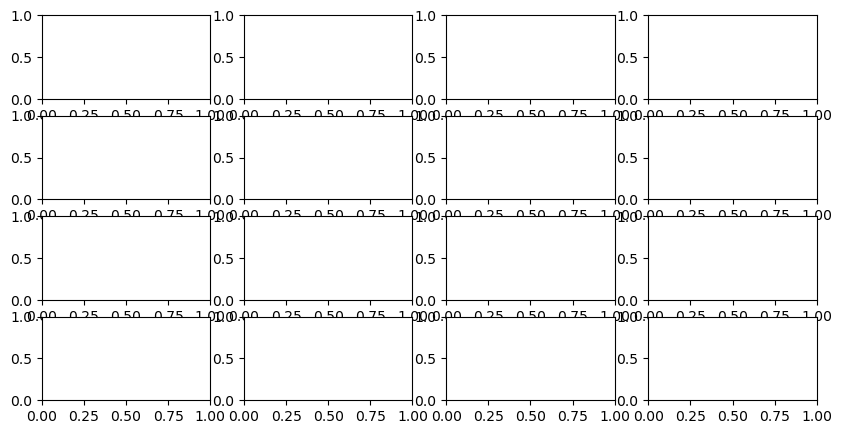

In [15]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(batch_size):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

Define and get the model

In [7]:

# CTC = Connectionist Temporal Classification, méthode connectable dans des réseaux de neurones
# permettant entre autre d'identifier des séquences de données temporelles

# The CTC alorithms assign a probability for any Y given an X. Its goal is to allign the input and the output.
# For example in an OCR, it will assign each output a propability for a given handwritten chatacter

# Convolutional block :
#    - Convolutional Layer : aid in dedetecing patterns in our image
#    - Pooling layers : 
#           The problem with the convolutional layers is that they record the precise position
#           of features in the input. This leans that small movements in the position of the feature in
#           input image will result in a different feature map. Thic can happen with re-cropping, rotation,
#           shiffting of the input image.
#           To overcome this problem, a common approach is down sampling the input. A lower resolution is apply
#           but it still contains the large or important structural elements, witout the fine details that may not
#           be useful to the task. It is done by using a pooling layer.
#           Pooling involves selecting a pooling operation. It is like applying a filter to each feature map to make it
#           smaller. For exammple; if it reduces the feature map by a factor of 2, each dimension is halved, this means
#           that the feature map will have the quarter of it's original size. 6*6 (36 pixels) => 3*3 (9 pixels).
#           The pooling operation is specified, rather than learned, thow common pooling functions are :
#               - Average pooling : Calculate the average value for each patch on the feature map
#               - Maximum pooling : Calculate the maximum value for each path on the feature map
#           The result is a summarized version of the features detected in the input. They are useful because small changes
#           in the input will produce the same feature map. Thid capability added by pooling is called "the model's invariance
#           to local translation".
#           pooling helps to make the representaion become approximately invariant to small translations of the input. If we translate
#           the input by a small amount, the values of most of the pooled outputs do not change.
#   - Dropout layer :
#       Neural networks tends to memorize the input data instead of learning procedures and working. We can use a dropout layer to reduce this
#       this effect. The dropout layers randomly discard sme of the input data that passes trhough it. To summarize, we discard data to obtain a 
#       more accurate end results.

# Define CTCLayer class :

class CTCLayer(layers.Layer):
    def __init__(self, name=None) -> None:
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost #we use the batch_cost loss function
    
    def call(self, y_true, y_pred):
        # Compute the training-time loss vaue and add it
        # to the layer using `self.add_loss()`
        # tf.shape() = get the shape of the tensor (tensor = one or multi dimensional array e.g. a bit like numpy arrays). Returns also a tensor
        # tf.cast() = cast the given tensor into specified dtype
        # tf.ones () = create a tensor of the given shape fullfilled with ones (1) : ex : [[1, 1, 1], [1, 1, 1]]
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(shape=(None, ), name="label", dtype="float32")

    #First conv block
    # layers.Convo2D() creates a 2D convolution layer (e.g. spatial convolution over images)
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1"
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2"
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    # RNN = Recurent Neural Network
    # This is a type if algorithm that remember its input, due t an internal memory, which make it well suited for machine learning
    # problems that involve sequential data. With sequential or time series data, feedforwars networks cannot be used for learning and
    # prediction. A mechanism (RNN for example) is required to retain past or historical information to forecast future values.
    # Recurent Neural Network (RNN) are a variant of the conventional feedforward artificial neural networks that can dead with
    # sequential data and can be trained to hold knowledge about the past.
    
    # LSTM (Long Short Term Memory) = modified version of recurrent neural networks, which make it easier to remember past data in memory.
    # LSTM is well suited to classify, process and predict time series given time lags of unknown duration.
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Outpout layer
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at eacgh step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")

    # Optimizer
    # Optimizers are algorithms used to update tje âraùeters of a neural networks such as weights and learning rate to reduce the losses.
    # Optimizers are used to solve optimizatio problems by minimizing the cost function.
    opt = keras.optimizers.Adam()

    # Compile the model
    model.compile(optimizer=opt)

    # Return the model
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

Training

In [8]:
epochs = 1
# Early stopping is a method that allows you to specify an arbitrarily large number of training epocs
# #and stop training once the model performance stop improving on the validation dataset
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

59/59 [==============================] - 69s 780ms/step - loss: 20.6886 - val_loss: 16.3654


Get the predictions

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

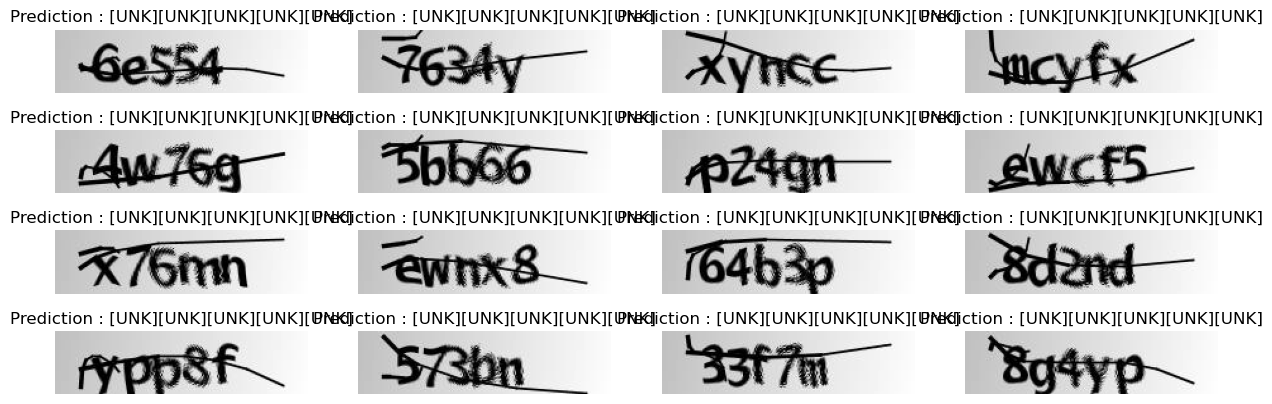

In [9]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name='image').input, model.get_layer(name='dense2').output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    # Iterate over the result and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Let's check the result of some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images[0])

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction : {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    plt.show()

### Save the model

In [10]:
model.save('./ocr-captcha-model/')

KeyboardInterrupt: 